# Programming Exercise 3B: Hodgkin-Huxley Model

In this exercise, we implement the Hodgkin-Huxley model that we discussed in the lecture. The model is governed by the following set of equations:

$$
\begin{align}
	C_m \frac{\operatorname{d}V}{\operatorname{d}t}
		&=  I_e\left(t\right)  -\bar{g}_L \left( V -E_L\right) -\bar{g}_\text{Na} m^3 h \left( V -E_\text{Na}\right) 	-\bar{g}_\text{K} n^4 \left( V -E_\text{K}\right),\\
	\frac{\operatorname{d}m}{\operatorname{d}t}	
	&= \alpha_m \left( 1-m\right) -\beta_m m,\\
	\alpha_m
	&=\left\{
		\begin{array}{l l}
    			0.1 \frac{ V -25 }{1-\exp \left( - \frac{ V-25}{10} \right)},  & \quad V \neq 25mV\\
    			1, & \quad V = 25mV,\\
  		\end{array}
    	\right. \\    	
	\beta_m
	&= 4 \exp \left( - \frac{V}{18}\right), \\
	 \frac{\operatorname{d}h}{\operatorname{d}t}	
	 &= \alpha_h \left( 1-h\right) -\beta_h h, \\
 \alpha_h
 	&=  0.07 \exp \left( -\frac{V}{20} \right), \\
	  \beta_h
	  &= \frac{1}{1+ \exp \left( -\frac{V-30}{10}\right) },		\\
	\frac{\operatorname{d}n}{\operatorname{d}t}	
	&= \alpha_n \left( 1-n\right) -\beta_n n, \\
	\alpha_n 	&=\left\{
		\begin{array}{l l}
    			0.01 \frac{ V -10}{1-\exp \left( - \frac{ V-10}{10} \right)},  & \quad V \neq 10mV\\
    			0.1, & \quad V = 10mV,\\
  		\end{array}
    	\right. \\
	 \quad	\beta_n
	 &= 0.125 \exp \left( - \frac{V}{80}\right).
\end{align}
$$

We assume the electrical properties
<ul>
<li>$C_m = 1 \mu F $, membrane capacitance,</li>

<li>$E_\text{Na} = 115 mV$, sodium equilibrium potential,</li>

<li>$E_\text{K} = -12 mV$, potassium equilibrium potential,</li>

<li>$E_\text{L} = 10.6 mV$, leak equilibrium potential,</li>

<li>$V\left(0\right)=0mV$, (starting) membrane resting potential,</li>

<li>$\bar{g}_\text{Na} = 120  mS$, maximum conductance for sodium channel,</li>

<li>$\bar{g}_\text{K} = 36  mS$, maximum conductance for potassium channel,</li>

<li>$\bar{g}_\text{L} = 0.3  mS$, maximum leak conductance.</li>
</ul>

**When implementing the model, we drop all units.** This will simplify the implementation and remove a possible source of bugs. This also pertains to the equations above; the voltage is measured in mV in all equations in this notebook.

<div class="alert alert-block alert-success">
<b>Task:</b> Implement the electrical parameters.
</div>

In [32]:
import numpy as np
import matplotlib.pyplot as plt

### YOUR CODE HERE ###

C_m = 1 #uF
E_Na = 115 #mV
E_K = -12 #mV
E_L = 10.6 #mV
V_0 = 0 #mV
g_Na = 120 #mS
g_K = 36 #mS
g_L = 0.3 #mS

### YOUR CODE HERE ###

The equations above can be interpreted hierachically. The values $\alpha$ and $\beta$ are needed to compute the gating variables and the gating variables are needed to compute the derivative of the membrane potential.

To implement the many little functions, we will use Python's lambda calculus. If you are unfamiliar, here is a short introduction: https://www.w3schools.com/python/python_lambda.asp. In our case, it simply let's us write our functions as one-liners.

<div class="alert alert-block alert-success">
<b>Task:</b> Write the remaining lambda functions necessary to compute the derivatives of all gating variables.
</div>

In [33]:
### YOUR CODE HERE ###

alpha_m = lambda V : 1 if V == 25 else 0.1 * (V - 25) / (1 - np.exp(- (V - 25) / 10))
beta_m = lambda V : 4 * np.exp(- V / 18)
dm_dt = lambda m, V : alpha_m(V) * (1 - m) - beta_m(V) * m

alpha_h = lambda V: 0.07*np.exp(-V/20)
beta_h = lambda V: 1/(1+np.exp(-(V-30)/10))
dh_dt = lambda h, V: alpha_h(V) * (1-h) - beta_h(V) * h

alpha_n = lambda V: 0.1 if V == 10 else 0.01*(V-10)/(1 - np.exp(-(V-10)/10))
beta_n = lambda V: 0.125*np.exp(-V/80)
dn_dt = lambda n, V: alpha_n(V) * (1-n) - beta_n(V) * n

### YOUR CODE HERE ###

Assume that, at the beginning of the simulation, the voltage is given by $V_0 = E_m = 0mV$. In the resting state, we do not want the gating variables to change; thus, we need to start our model not only at resting potential $V_0$, but also at the steady-state values for the gating variables $m$, $h$, and $n$ at potential $V_0$. We saw in the lecture, that the steady-state values for a given voltage $V$ are
$$
x(\infty) = \frac{\alpha_x(V)}{\alpha_x(V) + \beta_x(V)},
$$
where $x \in \{ m,h,n \}$.

<div class="alert alert-block alert-success">
<b>Task:</b> Write lambda functions to compute the steady-state solution for all gating variables as a function of V.
</div>

In [34]:
### YOUR CODE HERE ###
m_inf = lambda V: alpha_m(V)/(alpha_m(V)+beta_m(V))
h_inf = lambda V: alpha_h(V)/(alpha_h(V)+beta_h(V))
n_inf = lambda V: alpha_n(V)/(alpha_n(V)+beta_n(V))
### YOUR CODE HERE ###

At this point, we have implemented all model equations except for the voltage's derivative. Let's implement it for given values of $I_e$, $m$, $h$ and $n$.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function dV_dt() to compute the derivative of the voltage.
</div>

In [35]:
def dV_dt(V, I_e, C_m, E_L, E_Na, E_K, g_L, g_Na, g_K, m, h, n):
    ''' Implements the voltage derivative.
    Args:
        V: Current Membrane potential in mV
        I_e: Current current input in uA
        C_m: Membrane capacitance in uF
        E_L: Leak equilibrium potential in mV
        E_Na: Na equilibrium potential in mV
        E_K: K equilibrium potential in mV
        g_L: Maximum leak conductance in mS
        g_Na:Maximum Na conductance in mS
        g_K: Maximum K conductance in mS
        m: Current value for m
        h: Current value for h
        n: Current value for n

    Returns: Derivative of the voltage
    '''
    
    ### YOUR CODE HERE ###
    dVdt = (I_e - g_L * (V - E_L) - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K))/C_m

    ### YOUR CODE HERE ###
    return dVdt

Consider as input a rectangle pulse current of the form
$$
I_e(t) = 
\begin{cases}
0, & (t < t_e) \vee (t_s \leq t) \\
I_0, & (t_e \leq t < t_s)
\end{cases}.
$$

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function rectangular_input() to implement the input current $I_e(\cdot )$.
</div>

In [36]:
def rectangular_input(t, I_0, t_e, t_s):
    '''Implements the rectangle-input function.
    Args:
        t: Time in miliseconds
        I_0: The value of the input current
        t_e: start time in miliseconds
        t_e: end time in miliseconds

    Returns:
        The input current at a given time
    '''
    
    ### YOUR CODE HERE ###
    if t_e <= t < t_s:
        I_e = I_0
    else:
        I_e = 0

    return I_e    
    ### YOUR CODE HERE ###


We have now implemented all component functions. In order to simulate the HH model we use Euler's method as in Exercise 2.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function simulate_HH() so that it returns the time-dependent membrane potential for a given time interval.
    
<i>Hint:</i> Start your model at $V_0$ and set the gating variables to the corresponding steady-state values. At each time step, update your values for the gating variables and the voltage.
</div>

In [37]:
def simulate_HH(V_0, input_current_fun, input_current_params, t_start, t_stop, delta_t,
                C_m, E_L, E_Na, E_K, g_L, g_Na, g_K):
    ''' Runs the HH simulation. The function should return the time axis over which the simulation was run, and the
    voltage at each of the time steps.
    Args:
        V_0: Starting (resting) voltage
        input_current_fun: Name of the input current function
        input_current_params: List of arguments that the current input function takes after t
        t_start: Start time of the simulation in ms
        t_stop: End time of the simulation in ms
        delta_t: Euler step length in ms
        C_m: Membrane capacitance in uF
        E_L: Leak equilibrium potential in mV
        E_Na: Na equilibrium potential in mV
        E_K: K equilibrium potential in mV
        g_L: Maximum leak conductance in mS
        g_Na:Maximum Na conductance in mS
        g_K: Maximum K conductance in mS

    Returns: time axis, voltage axis in ms and mV
    '''
    
    ### YOUR CODE HERE ###
    
    time_axis = np.arange(t_start, t_stop, delta_t)
    sol = np.zeros((len(time_axis), 5))
    # sol is the solution in the form [V, m, h, n, I_e]
    # Feel free to delete the code and start from scratch
    sol[0,:] = V_0, m_inf(V_0), h_inf(V_0), n_inf(V_0), input_current_fun(t_start, *input_current_params)
    V = V_0
    m,h,n = m_inf(V), h_inf(V), n_inf(V)

    for i, t in enumerate(time_axis[1:]):
        I_e = input_current_fun(t, *input_current_params)
        
        m += dm_dt(m,V) * delta_t
        h += dh_dt(h,V) * delta_t
        n += dn_dt(n,V) * delta_t
        V += dV_dt(V, I_e, C_m, E_L, E_Na, E_K, g_L, g_Na, g_K, m, h, n) * delta_t

        sol[i,:] = V, m_inf(V), h_inf(V), n_inf(V), I_e
    
    return time_axis, sol
    
    
    ### YOUR CODE HERE ###

Let's set the values of the input-current parameters as $t_e = 50ms$ and $t_s = 300ms$. Then we run the simulation for $500ms$ for different values of the input current $I_0$, namely
<ul>
  <li>$0\mu A$,</li>
  <li>$3\mu A$,</li>
  <li>$6\mu A$,</li>
  <li>$8\mu A$.</li>

</ul>

In [38]:
t_start, t_stop, delta_t = 0, 500, 0.025 #ms
t_e, t_s = 50, 300 #ms
I_0_list = [0, 3, 6, 8] #muA

<div class="alert alert-block alert-success">
<b>Task:</b> Run the simulation for the given values, and plot the voltage against time.
</div>

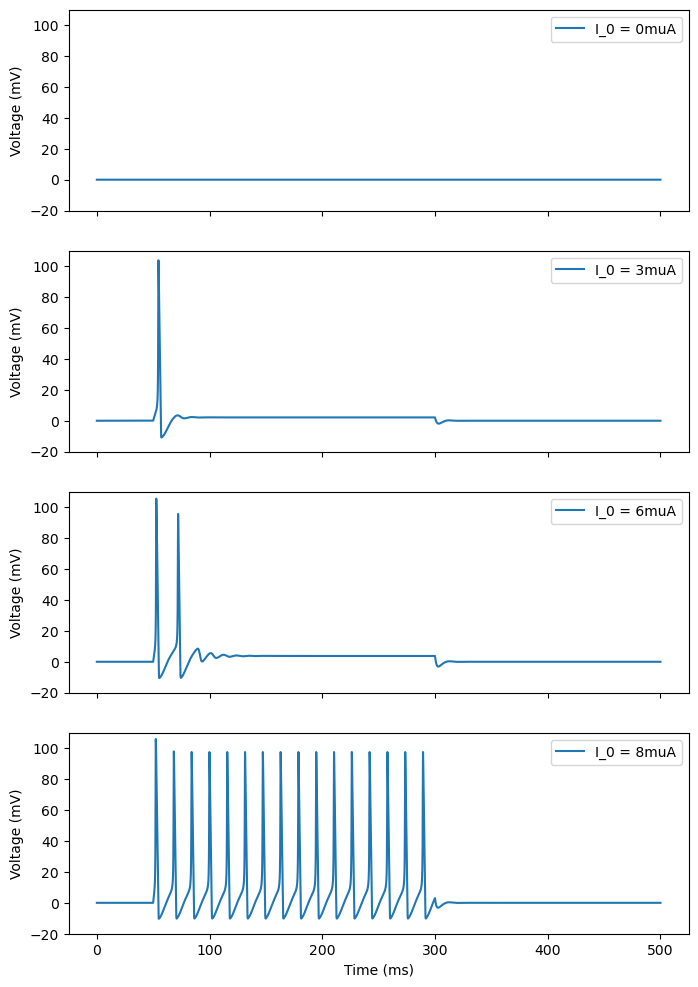

In [39]:
### YOUR CODE HERE ###
fig, ax = plt.subplots(4,1, figsize = (8, 12), sharex=True)
for i, I_0 in enumerate(I_0_list):
    input_current_params= [I_0, t_e, t_s]
    time_axis, sol= simulate_HH(V_0, rectangular_input, input_current_params, t_start, t_stop, delta_t,
                                C_m, E_L, E_Na, E_K, g_L, g_Na, g_K)
    
    ax[i].set_ylim(-20, 110)
    ax[i].plot(time_axis,sol[:,0], label = f'I_0 = {I_0}muA')
    ax[3].set_xlabel("Time (ms)")
    ax[i].set_ylabel("Voltage (mV)")
    ax[i].legend()
### YOUR CODE HERE ###

<div class="alert alert-block alert-success">
<b>Task:</b> Summarize the findings.
</div>

**Your Answer:** No spikes occurred during the first current, as no current was injected. Increasing the current led to more spikes. In the second and third cases, spikes appeared with currents up to 300 ms, but only reached continuous generation at 8 uA. This indicates a minimum current needed for continuous spike generation, with spikes stopping when the current injection ceases.

Finally, it is interesting to study how the firing rate of the neuron changes with input current.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the function compute_firing_rate() to compute the number of spikes per unit time for a given solution of the HH model.

<i>Hint:</i> Count the times the voltage passes a certain threshhold (only one direction!) and normalize across time. 
</div>

In [40]:
def compute_firing_rate(V, delta_t, threshhold, t_1, t_2):
    ''' Computes the firing rate of a solution of the HH model.
    Args:
        V: The voltages over time as output by simulate_HH()
        delta_t: The time constant used in the simulation
        threshhold: Threshhold value that defines a spike
        t_1: Beginning of the time interval in which spikes are counted in ms
        t_2: End of the time interval in which spikes are counted in ms

    Returns: The firing rate
    '''
    
    ### YOUR CODE HERE ###
    count = 0
    for v in V[int(t_1/delta_t):int(t_2/delta_t)]:
        if (v > threshhold) and (v_1 < threshhold):
            count += 1
        v_1 = v
    
    firing_rate = count/(t_2-t_1)
    return firing_rate

    ### YOUR CODE HERE ###

<div class="alert alert-block alert-success">
<b>Task:</b> Compute the firing rate for input currents $I_0$ between $0\mu A$ and $20\mu A$ with steps of $0.5\mu A$. Plot the firing rate against the input current. What do you observe?

<i>Hint:</i> To make the plot a bit smoother, you can increase the time window in which current is injected, to get a more robust estimate of the fire rate. Keep all other parameters the same.

</div>

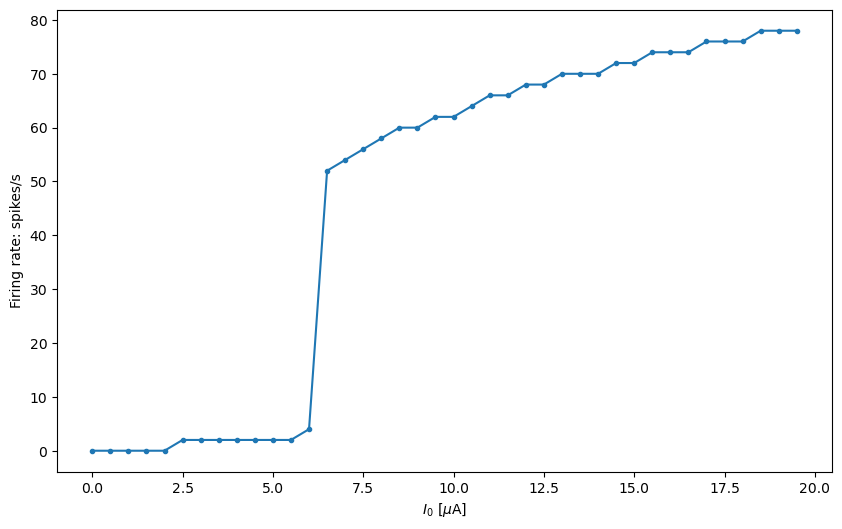

In [41]:
# Make the firing interval longer to smoothen the curve. _fr denotes the "firing rate task"
t_s_fr = 500

### YOUR CODE HERE
I_0_list = np.arange(0,20,0.5)
firing_rate =[]

for I_0 in I_0_list:
    input_current_params= [I_0, t_e, t_s_fr]
    time_axis, sol= simulate_HH(V_0, rectangular_input, input_current_params, t_start, t_stop, delta_t,
                                C_m, E_L, E_Na, E_K, g_L, g_Na, g_K)
    firing_rate.append(compute_firing_rate(sol[:,0], delta_t, 80, t_start, t_s_fr))

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(I_0_list,[i*1000 for i in firing_rate], '.-')
ax.set_xlabel(r"$I_0$ [$\mu$A]")
ax.set_ylabel("Firing rate: spikes/s")
plt.show()
### YOUR CODE HERE ###

**Your Answer:** The Hodgkin-Huxley model shows a discontinuity. Above a critical current of around 6 uA, it triggers regular, continuous spiking, while below this threshold, occasional spikes may occur before settling into a quiescent state, as observed in the plot for values below 6 uA.